Run with Python 3.8

***This notebook generates Figure S3 in Appendix S1.***

* Python 3.8
* pandas 2.0.3
* numpy 1.24.3
* matplotlib 3.6.0

In [1]:
# Import standard libraries
import os
import copy

# Import published packages from PyPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Specify directories**

In [2]:
DATA_IN = 'datasets'
DATA_OUT = 'out'

# Load data

Original data from https://datadryad.org/stash/dataset/doi:10.5061%2Fdryad.84fq2vh

Time period of entire dataset: 12/31/2000 9PM through 12/31/2022 2AM

Note there is a slight difference between the data published online versus data in the `datasets` folder, due to minor errors in data processing caught after publication especially for the 2011 time series. Data from 2016 through 2022 have not yet been published.

In [3]:
# Time period: 12/31/2000 9PM through 12/31/2022 2AM
raw_anuran_df = pd.read_csv(
    os.path.join(DATA_IN, 'nightlycalls.csv'), 
    index_col = False, 
    parse_dates = ['date']
)

# Data wrangling

In [4]:
raw_anuran_df.rename(
    columns = {'year': 'calendar_year', 'date': 'date_obj'}, 
    inplace = True
)

**Remove any duplicate data**

In [5]:
raw_anuran_df.drop_duplicates(inplace = True, ignore_index = True)

**Address null values**

In [6]:
# should only be null values in nightlysum column for when data loggers cut out 
#  for unclear reasons
raw_anuran_df.isnull().any()

pond             False
date_obj         False
sp               False
nightlysum        True
calendar_year    False
doy              False
dtype: bool

**Correct data types**

In [7]:
base_anuran_df = raw_anuran_df.astype({
    'pond': np.int8, 
    'calendar_year': np.int16, 
    'doy': np.int16, 
})
base_anuran_df.head()

,pond,date_obj,sp,nightlysum,calendar_year,doy
0,1,2000-12-31,HV,0.0,2000,366
1,1,2000-12-31,HC,0.0,2000,366
2,1,2000-12-31,BV,0.0,2000,366
3,1,2000-12-31,BW,0.0,2000,366
4,1,2000-12-31,RCA,0.0,2000,366


**Add helpful columns**

`sampling_year`: year of the last 3 hours of nightly data, which standardizes the number of data entries per year

In [8]:
# Helper functions

def sampling_year(date_obj: str, year: int):
    if date_obj.month == 12 and date_obj.day == 31:
        return year + 1
    return year

In [9]:
base_anuran_df['sampling_year'] = base_anuran_df.apply(
    lambda x: sampling_year(x.date_obj, x.calendar_year), 
    axis = 1
)

base_anuran_df.head()

,pond,date_obj,sp,nightlysum,calendar_year,doy,sampling_year
0,1,2000-12-31,HV,0.0,2000,366,2001
1,1,2000-12-31,HC,0.0,2000,366,2001
2,1,2000-12-31,BV,0.0,2000,366,2001
3,1,2000-12-31,BW,0.0,2000,366,2001
4,1,2000-12-31,RCA,0.0,2000,366,2001


# Rana sphenocephala activity

In [11]:
RS_df = base_anuran_df.loc[base_anuran_df['sp'] == "RS"]
RS_null_df = RS_df.loc[RS_df['nightlysum'].isnull()]
RS_active_df = RS_df.loc[RS_df['nightlysum'] > 0]
RS_inactive_df = RS_df.loc[RS_df['nightlysum'] == 0]

In [12]:
RS_inactive_doys_across_ponds_dict = {}
for y, group in RS_inactive_df.groupby('sampling_year')['doy']:
    active_doys_year = set(RS_active_df.loc[
        RS_active_df['sampling_year'] == y 
    ]['doy'])
    RS_inactive_doys_across_ponds_dict[y] = set(group) - active_doys_year

# get corresponding df's for next step
RS_inactive_doys_across_ponds_df_list = []
for y, group in RS_df.groupby('sampling_year'):
    if len(RS_inactive_doys_across_ponds_dict[y]) > 0:
        RS_inactive_doys_across_ponds_df_list.append(
            group[group['doy'].isin(RS_inactive_doys_across_ponds_dict[y])]
        )
RS_inactive_doys_across_ponds_df = pd.concat(
    RS_inactive_doys_across_ponds_df_list
)

# select subset in RS_inactive_doys_across_ponds_dict when we consider species 
#  as inactive, using inactivity in under half of ponds to remove semi-active 
#  days of year
RS_no_obs_doys_dict = {}
for y, group in RS_inactive_doys_across_ponds_df.groupby('sampling_year'):
    RS_no_obs_doys_dict[y] = copy.deepcopy(
        RS_inactive_doys_across_ponds_dict[y]
    )
    for doy, g in group.groupby('doy'):
        if len(set(g['pond'])) < 0.5 * len(
            base_anuran_df['pond'].unique()
        ):
            RS_no_obs_doys_dict[y] -= doy

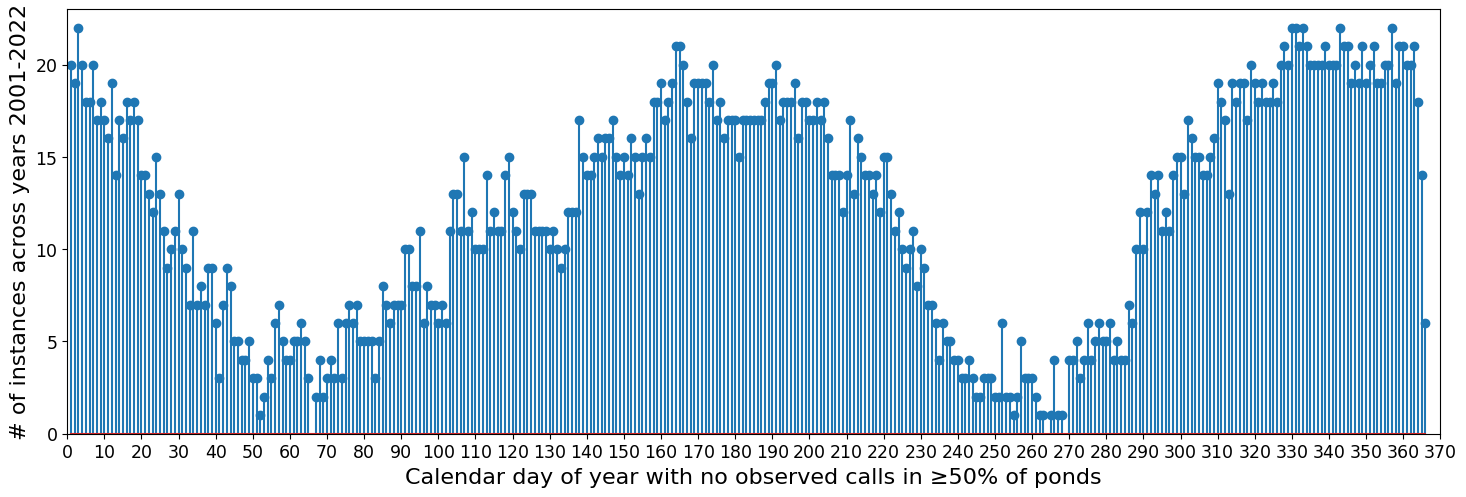

Days of year always active:  {264, 66, 269}


In [13]:
RS_no_obs_doys_counts_list = []
RS_no_obs_doys_list = []
years = np.arange(2001, 2023)
for y, _ in RS_no_obs_doys_dict.items():
    RS_no_obs_doys_list += RS_no_obs_doys_dict[y]
for doy in sorted(set(RS_no_obs_doys_list)):
    RS_no_obs_doys_counts_list += [RS_no_obs_doys_list.count(doy)]

# x is doy, y is count of each doy
cm = 1 / 2.54  # centimeters in inches for figsize default units
fig, ax = plt.subplots(figsize = (45 * cm, 14 * cm))
ax.stem(
    sorted(set(RS_no_obs_doys_list)), 
    RS_no_obs_doys_counts_list
)
ax.set(
    xlim = (0, 368), 
    xticks = np.linspace(start = 0, stop = 370, num = 38), 
    ylim = (0, len(years) + 1)
)
ax.set_xlabel(
    xlabel = "Calendar day of year with no observed calls in ≥50% of ponds", 
    fontsize = 16.0
)
ax.set_ylabel(
    ylabel = "# of instances across years 2001-2022", 
    fontsize = 16.0
)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12.5)
plt.show()
fig.savefig(
    os.path.join(DATA_OUT, 'figure_s3.png'), 
    bbox_inches = 'tight', 
    dpi = 300
)

# this study selected days of year 66 and 264 to define "spring" and "fall"
#  R. sphenocephala calling phenophases
print(
    "Days of year always active: ", 
    set(range(1, 367)) - set(RS_no_obs_doys_list)
)